# Binary-Class Tabular Model for Kaggle Playground Series Season 3 Episode 2 Using Python and TensorFlow Decision Forests
### David Lowe
### January 24, 2023

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Playground Series Season 3 Episode 2 dataset is a binary-class modeling situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions to give the Kaggle community a variety of reasonably lightweight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science. The dataset for this competition was generated from a deep learning model trained on the Stroke Prediction Dataset. Feature distributions are close to but different from the original.

ANALYSIS: The Random Forest model performed the best with the training dataset. The model achieved an AUC/ROC benchmark of 0.9914. When we processed the test dataset with the final model, the model achieved an AUC/ROC score of 0.8731.

CONCLUSION: In this iteration, the Random Forest model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Playground Series Season 3, Episode 2

Dataset ML Model: Binary-Class classification with numerical and categorical features

Dataset Reference: https://www.kaggle.com/competitions/playground-series-s3e2

One source of potential performance benchmarks: https://www.kaggle.com/competitions/playground-series-s3e2/leaderboard

## Task 1 - Prepare Environment

In [1]:
# Install TensorFlow Decision Forests
!pip3 install tensorflow_decision_forests --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [3]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [4]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
import zipfile
import urllib
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import metrics
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
# from tensorflow import keras
import tensorflow_decision_forests as tfdf

### 1.b) Set up the controlling parameters and functions

In [5]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the name for the class/label column
ORIGINAL_LABEL = 'stroke'
CLASS_COLUMN = 'target'

# Set the number of folds for cross validation
N_FOLDS = 10
N_ITERATIONS = 1

# Set default modeling scoring metric
DEFAULT_METRICS = [tf.keras.metrics.AUC()]

# Define the directory locations and file names
ORIGINAL_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e02/healthcare-dataset-stroke-data.csv'
TRAIN_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e02/train.csv'
TEST_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e02/test.csv'
SUBMISSION_TEMPLATE = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e02/sample_submission.csv'
SUBMISSION_FILE = 'submission_decisionforests_'

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow version: 2.11.0
Found TensorFlow Decision Forests v1.1.0


In [6]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [7]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [8]:
df_dataset_import = pd.read_csv(TRAIN_DATASET)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id  gender   age  hypertension  heart_disease ever_married work_type  \
0   0    Male  28.0             0              0          Yes   Private   
1   1    Male  33.0             0              0          Yes   Private   
2   2  Female  42.0             0              0          Yes   Private   
3   3    Male  56.0             0              0          Yes   Private   
4   4  Female  24.0             0              0           No   Private   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban              79.53  31.1     never smoked       0  
1          Rural              78.44  23.9  formerly smoked       0  
2          Rural             103.00  40.3          Unknown       0  
3          Urban              64.87  28.8     never smoked       0  
4          Rural              73.36  28.8     never smoked       0  


In [9]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


In [10]:
print(df_dataset_import.describe())

                 id           age  hypertension  heart_disease  \
count  15304.000000  15304.000000  15304.000000   15304.000000   
mean    7651.500000     41.417708      0.049726       0.023327   
std     4418.028595     21.444673      0.217384       0.150946   
min        0.000000      0.080000      0.000000       0.000000   
25%     3825.750000     26.000000      0.000000       0.000000   
50%     7651.500000     43.000000      0.000000       0.000000   
75%    11477.250000     57.000000      0.000000       0.000000   
max    15303.000000     82.000000      1.000000       1.000000   

       avg_glucose_level           bmi        stroke  
count       15304.000000  15304.000000  15304.000000  
mean           89.039853     28.112721      0.041296  
std            25.476102      6.722315      0.198981  
min            55.220000     10.300000      0.000000  
25%            74.900000     23.500000      0.000000  
50%            85.120000     27.600000      0.000000  
75%            96.98

In [11]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64
Total number of NaN in the dataframe:  0


In [12]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(ORIGINAL_LABEL).size())

stroke
0    14672
1      632
dtype: int64


### 1.d) Data Cleaning

In [13]:
# Fetch the original dataset and use it to supplement the training
df_dataset_original = pd.read_csv(ORIGINAL_DATASET)
df_dataset_original['is_synthetic'] = 0

# Take a peek at the dataframe after import
print(df_dataset_original.head())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  is_synthetic  
0       1             0  
1       1             0  
2       1             0  
3       1             0 

In [14]:
df_dataset_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
 12  is_synthetic       5110 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 519.1+ KB


In [15]:
# Combine the original and synthetic datasets into one training dataset
df_dataset_import['is_synthetic'] = 1

df_dataset_import = pd.concat([df_dataset_import, df_dataset_original],
                              ignore_index=True)
df_dataset_import.drop(columns=['id'], inplace=True)

df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20414 entries, 0 to 20413
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             20414 non-null  object 
 1   age                20414 non-null  float64
 2   hypertension       20414 non-null  int64  
 3   heart_disease      20414 non-null  int64  
 4   ever_married       20414 non-null  object 
 5   work_type          20414 non-null  object 
 6   Residence_type     20414 non-null  object 
 7   avg_glucose_level  20414 non-null  float64
 8   bmi                20213 non-null  float64
 9   smoking_status     20414 non-null  object 
 10  stroke             20414 non-null  int64  
 11  is_synthetic       20414 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.9+ MB


In [16]:
def clean_gender(target_col):
    # print(target_col)
    if target_col == 'Other':
        return 'Male'
    else:
        return target_col

def clean_smoking_status(target_col):
    # print(target_col)
    if target_col == 'Unknown':
        return 'never smoked'
    else:
        return target_col

In [17]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Fill in some missing fields with the most common values
df_dataset_import['gender'] = df_dataset_import['gender'].apply(clean_gender)
df_dataset_import['smoking_status'] = df_dataset_import['smoking_status'].apply(clean_smoking_status)
median_bmi = df_dataset_import['bmi'].median()
df_dataset_import['bmi'].fillna(value=median_bmi, inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())
print(df_dataset_import.tail())

   gender   age  hypertension  heart_disease ever_married work_type  \
0    Male  28.0             0              0          Yes   Private   
1    Male  33.0             0              0          Yes   Private   
2  Female  42.0             0              0          Yes   Private   
3    Male  56.0             0              0          Yes   Private   
4  Female  24.0             0              0           No   Private   

  Residence_type  avg_glucose_level   bmi   smoking_status  target  \
0          Urban              79.53  31.1     never smoked       0   
1          Rural              78.44  23.9  formerly smoked       0   
2          Rural             103.00  40.3     never smoked       0   
3          Urban              64.87  28.8     never smoked       0   
4          Rural              73.36  28.8     never smoked       0   

   is_synthetic  
0             1  
1             1  
2             1  
3             1  
4             1  
       gender   age  hypertension  heart_dis

In [18]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20414 entries, 0 to 20413
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             20414 non-null  object 
 1   age                20414 non-null  float64
 2   hypertension       20414 non-null  int64  
 3   heart_disease      20414 non-null  int64  
 4   ever_married       20414 non-null  object 
 5   work_type          20414 non-null  object 
 6   Residence_type     20414 non-null  object 
 7   avg_glucose_level  20414 non-null  float64
 8   bmi                20414 non-null  float64
 9   smoking_status     20414 non-null  object 
 10  target             20414 non-null  int64  
 11  is_synthetic       20414 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.9+ MB


In [19]:
print(df_dataset_import.describe())

                age  hypertension  heart_disease  avg_glucose_level  \
count  20414.000000  20414.000000   20414.000000       20414.000000   
mean      41.870510      0.061673       0.031008          93.322256   
std       21.756482      0.240567       0.173344          32.476351   
min        0.080000      0.000000       0.000000          55.120000   
25%       25.000000      0.000000       0.000000          75.220000   
50%       43.000000      0.000000       0.000000          86.250000   
75%       58.000000      0.000000       0.000000          99.730000   
max       82.000000      1.000000       1.000000         271.740000   

                bmi        target  is_synthetic  
count  20414.000000  20414.000000  20414.000000  
mean      28.296350      0.043157      0.749682  
std        6.987362      0.203215      0.433207  
min       10.300000      0.000000      0.000000  
25%       23.500000      0.000000      0.000000  
50%       27.700000      0.000000      1.000000  
75%       

In [20]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
target               0
is_synthetic         0
dtype: int64
Total number of NaN in the dataframe:  0


In [21]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(CLASS_COLUMN).size())

target
0    19533
1      881
dtype: int64


### 1.e) Splitting Data into Sets

In [22]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (20414, 12) df_features_train.shape: (20414, 11) df_target_train.shape: (20414,)


### 1.f) Set up the parameters for data visualization

In [23]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [24]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [25]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

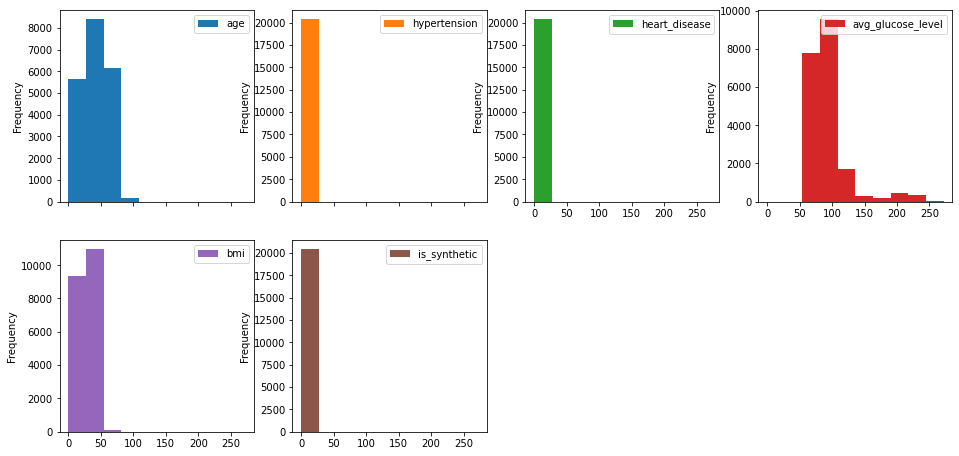

In [26]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

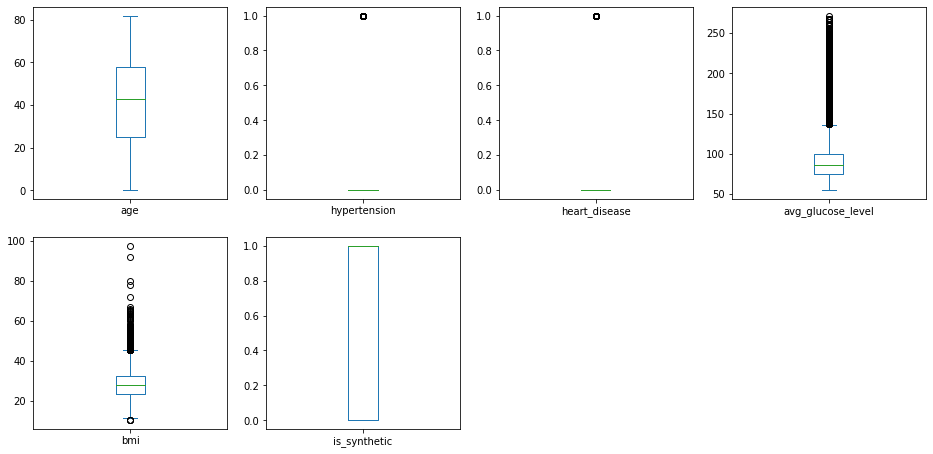

In [27]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

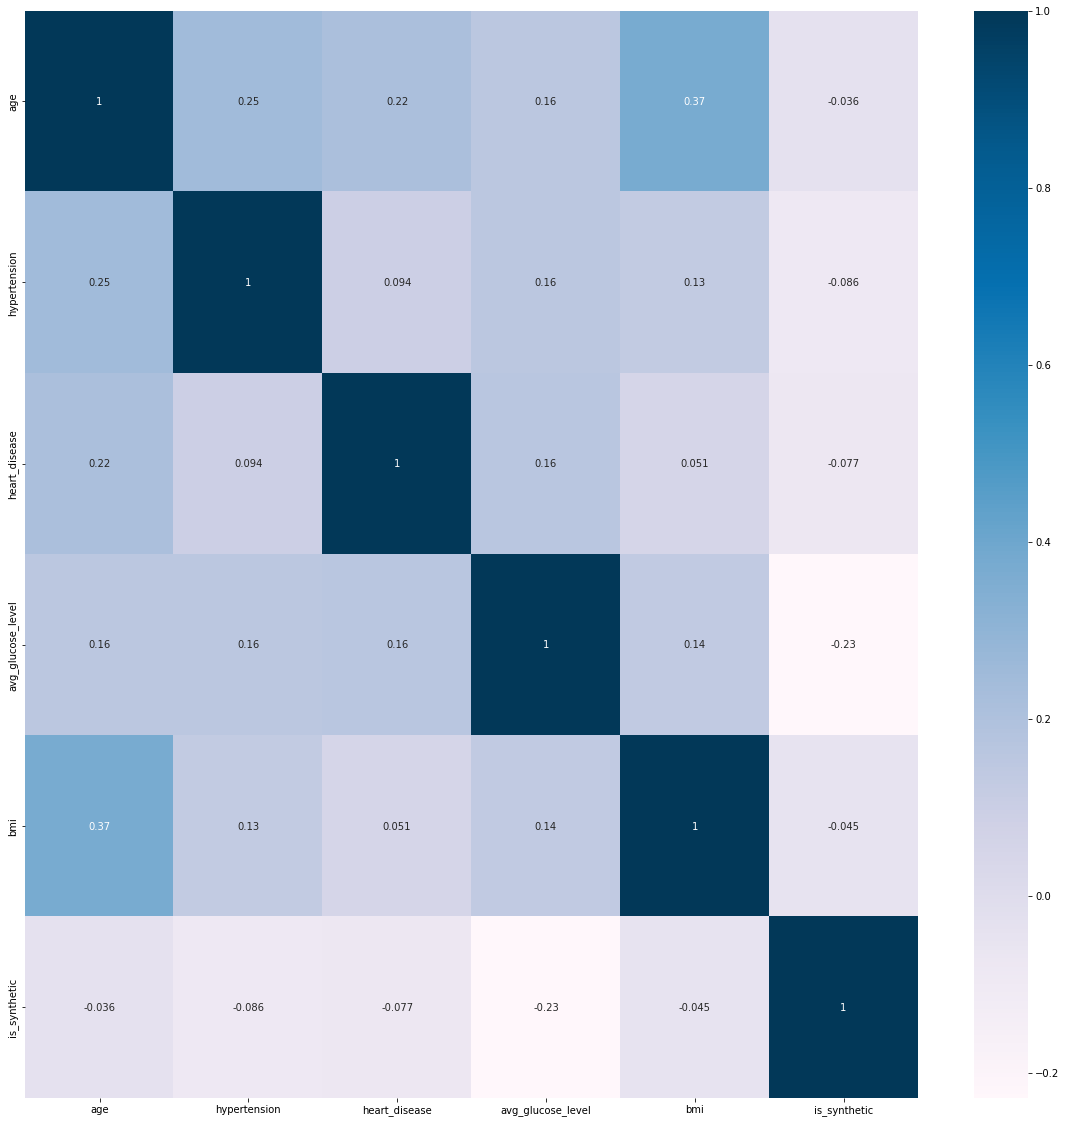

In [28]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [29]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [30]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [31]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_import, label='target', task = tfdf.keras.Task.CLASSIFICATION)

### 3.b) Train and Evaluate the Random Forest Model

In [32]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
RF_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)
RF_model.compile(metrics=DEFAULT_METRICS)
RF_model.fit(x=tfds_train)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Use /tmp/tmpzmd3ptgo as temporary training directory
Reading training dataset...


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:10.093693. Found 20414 examples.
Training model...
Model trained in 0:00:12.226260
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
Total time for model fitting: 0:00:30.464446


In [33]:
RF_model.evaluate(tfds_train)

21/21 [==============================] - 1s 49ms/step - loss: 0.0000e+00 - auc: 0.9914


[0.0, 0.9914087653160095]

In [34]:
RF_model.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (11):
	Residence_type
	age
	avg_glucose_level
	bmi
	ever_married
	gender
	heart_disease
	hypertension
	is_synthetic
	smoking_status
	work_type

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.           "__LABEL" 11.440291 ################
    2.    "Residence_type" 10.690514 ##############
    3.            "gender" 10.686519 ##############
    4.      "is_synthetic"  9.551275 #############
    5.     "heart_disease"  8.620983 ###########
    6.    "smoking_status"  8.564972 ###########
    7.         "work_type"  8.036176 ##########
    8.      "hypertension"  7.271919 #########
    9.      "ever_married"  6.511355 #####

### 3.c) Train and Evaluate the Decision Trees Model

In [35]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
CART_model = tfdf.keras.CartModel(task = tfdf.keras.Task.CLASSIFICATION)
CART_model.compile(metrics=DEFAULT_METRICS)
CART_model.fit(x=tfds_train)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Use /tmp/tmp5mdfb5nj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.414391. Found 20414 examples.
Training model...
Model trained in 0:00:00.081567
Compiling model...
Model compiled.
Total time for model fitting: 0:00:00.787812


In [36]:
CART_model.evaluate(tfds_train)

21/21 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - auc: 0.9267


[0.0, 0.9267293810844421]

In [37]:
CART_model.summary()

Model: "cart_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (11):
	Residence_type
	age
	avg_glucose_level
	bmi
	ever_married
	gender
	heart_disease
	hypertension
	is_synthetic
	smoking_status
	work_type

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.    "Residence_type"  6.416667 ################
    2.     "heart_disease"  6.416667 ################
    3.         "work_type"  6.416667 ################
    4.           "__LABEL"  6.416667 ################
    5.            "gender"  6.250000 ###############
    6.      "is_synthetic"  5.250000 #############
    7.      "ever_married"  4.750000 ###########
    8.    "smoking_status"  4.166667 ##########
    9.               "bmi"  3.500000


### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [38]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
GBT_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)
GBT_model.compile(metrics=DEFAULT_METRICS)
GBT_model.fit(x=tfds_train)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Use /tmp/tmp6qpi87jo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.396064. Found 20414 examples.
Training model...
Model trained in 0:00:03.464228
Compiling model...
Model compiled.
Total time for model fitting: 0:00:04.125642


In [39]:
GBT_model.evaluate(tfds_train)

21/21 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - auc: 0.9311


[0.0, 0.9311326742172241]

In [40]:
GBT_model.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (11):
	Residence_type
	age
	avg_glucose_level
	bmi
	ever_married
	gender
	heart_disease
	hypertension
	is_synthetic
	smoking_status
	work_type

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.           "__LABEL"  4.799330 ################
    2.      "ever_married"  4.729805 ###############
    3.            "gender"  4.725320 ###############
    4.    "Residence_type"  4.647241 ###############
    5.      "is_synthetic"  4.539785 ##############
    6.    "smoking_status"  4.441235 ##############
    7.      "hypertension"  4.402063 ##############
    8.     "heart_disease"  4.390904 ##############
    9

In [41]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [42]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [43]:
# Not applicable for this iteration of modeling

In [44]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [45]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [46]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
final_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)
# final_model = tfdf.keras.CartModel(task = tfdf.keras.Task.CLASSIFICATION)
# final_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)
final_model.compile(metrics=DEFAULT_METRICS)

# Train the model.
final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmpi7o0noa0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.447679. Found 20414 examples.
Training model...
Model trained in 0:00:07.755232
Compiling model...
Model compiled.
Model training time: 0:00:10.604706 



In [47]:
final_model.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (11):
	Residence_type
	age
	avg_glucose_level
	bmi
	ever_married
	gender
	heart_disease
	hypertension
	is_synthetic
	smoking_status
	work_type

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.           "__LABEL" 11.440291 ################
    2.    "Residence_type" 10.690514 ##############
    3.            "gender" 10.686519 ##############
    4.      "is_synthetic"  9.551275 #############
    5.     "heart_disease"  8.620983 ###########
    6.    "smoking_status"  8.564972 ###########
    7.         "work_type"  8.036176 ##########
    8.      "hypertension"  7.271919 #########
    9.      "ever_married"  6.511355 ###

### 5.b) Load Test Dataset and Make Predictions

In [48]:
df_features_test = pd.read_csv(TEST_DATASET)
df_features_test['is_synthetic'] = 1

# Fill in some missing fields with the most common values
df_features_test['gender'] = df_features_test['gender'].apply(clean_gender)
df_features_test['smoking_status'] = df_features_test['smoking_status'].apply(clean_smoking_status)

# Take a peek at the dataframe after import
print(df_features_test.head())

      id  gender   age  hypertension  heart_disease ever_married work_type  \
0  15304  Female  57.0             0              0          Yes   Private   
1  15305    Male  70.0             1              0          Yes   Private   
2  15306  Female   5.0             0              0           No  children   
3  15307  Female  56.0             0              0          Yes  Govt_job   
4  15308    Male  32.0             0              0          Yes   Private   

  Residence_type  avg_glucose_level   bmi smoking_status  is_synthetic  
0          Rural              82.54  33.4   never smoked             1  
1          Urban              72.06  28.5   never smoked             1  
2          Urban             103.72  19.5   never smoked             1  
3          Urban              69.24  41.4         smokes             1  
4          Rural             111.15  30.1         smokes             1  


In [49]:
df_features_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10204 entries, 0 to 10203
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 10204 non-null  int64  
 1   gender             10204 non-null  object 
 2   age                10204 non-null  float64
 3   hypertension       10204 non-null  int64  
 4   heart_disease      10204 non-null  int64  
 5   ever_married       10204 non-null  object 
 6   work_type          10204 non-null  object 
 7   Residence_type     10204 non-null  object 
 8   avg_glucose_level  10204 non-null  float64
 9   bmi                10204 non-null  float64
 10  smoking_status     10204 non-null  object 
 11  is_synthetic       10204 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 956.8+ KB


In [50]:
id_column_name = df_features_test.columns[0]
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission[id_column_name] = df_features_test[id_column_name]
print(df_kaggle_submission.head())

      id
0  15304
1  15305
2  15306
3  15307
4  15308


In [51]:
# Dropping unique identifier and unnecessary features
df_features_test.drop(columns=[id_column_name,], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

   gender   age  hypertension  heart_disease ever_married work_type  \
0  Female  57.0             0              0          Yes   Private   
1    Male  70.0             1              0          Yes   Private   
2  Female   5.0             0              0           No  children   
3  Female  56.0             0              0          Yes  Govt_job   
4    Male  32.0             0              0          Yes   Private   

  Residence_type  avg_glucose_level   bmi smoking_status  is_synthetic  
0          Rural              82.54  33.4   never smoked             1  
1          Urban              72.06  28.5   never smoked             1  
2          Urban             103.72  19.5   never smoked             1  
3          Urban              69.24  41.4         smokes             1  
4          Rural             111.15  30.1         smokes             1  


In [52]:
# Finalize the test dataset for the testing activities
tfds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_features_test, task = tfdf.keras.Task.CLASSIFICATION)

In [53]:
# Make batched predictions
test_predictions =  final_model.predict(tfds_test)
print(test_predictions)

11/11 [==============================] - 1s 52ms/step
[[0.        ]
 [0.10666663]
 [0.        ]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


In [54]:
df_sample_submission = pd.read_csv(SUBMISSION_TEMPLATE)
df_sample_submission.drop(columns=[id_column_name], inplace=True)
submission_header = list(df_sample_submission.columns)[0]
print(submission_header)

stroke


In [55]:
df_kaggle_submission[submission_header] = test_predictions
df_kaggle_submission[submission_header] = df_kaggle_submission[submission_header]
print(df_kaggle_submission.head())

      id    stroke
0  15304  0.000000
1  15305  0.106667
2  15306  0.000000
3  15307  0.066667
4  15308  0.003333


In [56]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = SUBMISSION_FILE + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_decisionforests_20230122-2344.csv


In [57]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [58]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:00:56.890542
